In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
from torch.autograd import Variable
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
from IPython.display import display, clear_output


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        latent_dim = 300
        c = 64 # capacity

        self.encoder = nn.Sequential(
            nn.Conv2d(1, c, 4,stride= 2, padding= 1), #64
            nn.LeakyReLU(0.2),
            nn.Conv2d(c, 2*c, 4,stride= 2, padding= 1), #32
            nn.LeakyReLU(0.2),
            nn.Conv2d(2*c, 4*c, 4,stride= 2, padding= 1), #16
            nn.LeakyReLU(0.2),
            nn.Conv2d(4*c, 8*c, 4,stride= 2, padding= 1), #8
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(8*c*8*8,latent_dim),
            #nn.LayerNorm(latent_dim)
            )
        

        self.lin_decoder = nn.Sequential(
             nn.Linear(latent_dim,100),
             nn.LeakyReLU(0.2),
             nn.Linear(100,100),
             nn.LeakyReLU(0.2),
             nn.Linear(100,500),
             nn.LeakyReLU(0.2),
             nn.Linear(500,128*128),
             nn.Flatten(),
             nn.Unflatten(1, (1,128,128)),    
            )       
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,8*c*8*8),
            nn.Unflatten(1, (8*c,8,8)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(8*c, 4*c, 4, stride= 2, padding= 1),
            nn.LeakyReLU(0.2),       
            nn.ConvTranspose2d(4*c, 2*c, 4, stride= 2, padding= 1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(2*c, c, 4, stride= 2, padding= 1), 
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(c, 1, 4, stride= 2, padding= 1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Unflatten(1, (1,128,128)), 
            )
        
    def forward(self, x):

        x = self.encoder(x)
        output = torch.sigmoid(self.decoder(x)  + 
                           self.lin_decoder(x) )
        return output


from google.colab import drive
drive.mount('/content/drive',force_remount=True)

PATH = './drive/MyDrive/Londei SOM/encoder.rete'
net= torch.load(PATH, map_location=torch.device('cpu'))


Mounted at /content/drive


In [10]:
!pip install minisom
#from minisom import MiniSom
som = torch.load('./drive/MyDrive/Londei SOM/som.rete')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=cdfbe8e44706cb1deb842f4d15faa35103098e8ef7daff1416395684d3729197
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


In [13]:
class SOMNet(nn.Module):
    def __init__(self):
        super(SOMNet, self).__init__()
        latent_dim = 1500
        c = 64 # capacity

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2*c, 4,stride= 2, padding= 1), #16
            nn.LeakyReLU(0.2),
            nn.Conv2d(2*c, 4*c, 4,stride= 2, padding= 1), #8
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(4*c*8*8,latent_dim),       
            )  


        self.lin_decoder = nn.Sequential(
             nn.Linear(latent_dim,100),
             nn.LeakyReLU(0.2),
             nn.Linear(100,100),
             nn.LeakyReLU(0.2),
             nn.Linear(100,500),
             nn.LeakyReLU(0.2),
             nn.Linear(500,128*128),
             nn.Flatten(),
             nn.Unflatten(1, (1,128,128)),    
            )       
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,8*c*8*8),
            nn.Unflatten(1, (8*c,8,8)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(8*c, 4*c, 4, stride= 2, padding= 1), #16
            nn.LeakyReLU(0.2),       
            nn.ConvTranspose2d(4*c, 2*c, 4, stride= 2, padding= 1), #32
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(2*c, c, 4, stride= 2, padding= 1), #64
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(c, 1, 4, stride= 2, padding= 1), #128
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Unflatten(1, (1,128,128)), 
            )
        
    def forward(self, x):

        x = self.encoder(x)
        output = torch.sigmoid(self.decoder(x)  + 
                           self.lin_decoder(x) )
        return output



PATH = './drive/MyDrive/Londei SOM/somnet-sine.rete'
somnet = torch.load(PATH, map_location=torch.device('cpu'))

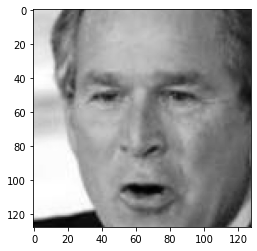

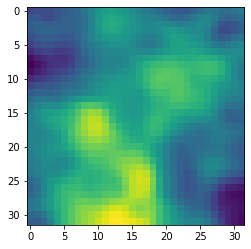

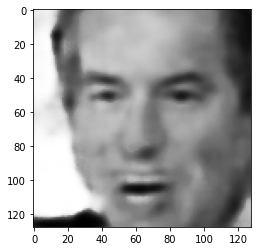

In [43]:
from matplotlib.image import imread

def im2act(immagine):
  encode = net.encoder(torch.Tensor(immagine[np.newaxis,np.newaxis]))
  act = - som.activate(encode[0].detach().cpu().numpy())
  return act

def act2im(act):
  act= torch.Tensor(act[ np.newaxis,  np.newaxis, ...])
  som_out = somnet(act)
  return som_out.cpu().detach().numpy()[0][0]


immagine  = imread('gino.png')[:,:,0]
plt.imshow(immagine, cmap='gray')
plt.show()

act = im2act(immagine)
plt.imshow(act)
plt.show()

im = act2im(act)
plt.imshow(im, cmap='gray')
plt.show()
